In [3]:
import pandas as pd
import yfinance as yf
import numpy as np
data = yf.download(['AMZN', 'MSFT', 'PEP', 'TSLA'],start='2015-01-01', end = '2020-01-01' )['Close']
data
log_ret_d = np.log(data/ data.shift(1)).dropna()
log_ret_w = log_ret_d.resample('W').sum()
log_ret_m = log_ret_d.resample('M').sum()
log_price = np.log(data)

/var/folders/32/x9dgly0d26z5yqyvl8t2zw3c0000gn/T/ipykernel_1029/963108069.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(['AMZN', 'MSFT', 'PEP', 'TSLA'],start='2015-01-01', end = '2020-01-01' )['Close']
[*********************100%***********************]  4 of 4 completed


[]

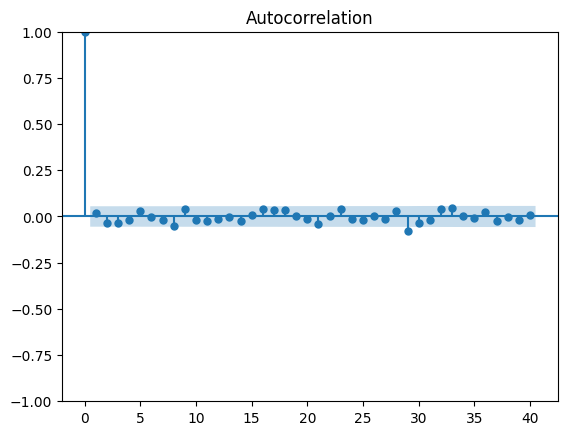

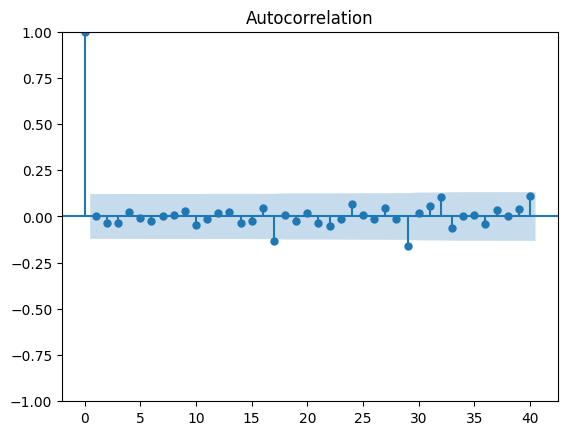

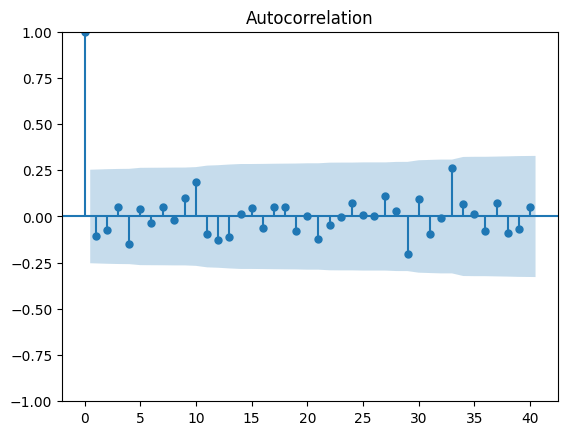

In [4]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(log_ret_d['AMZN'], lags = 40)
plot_acf(log_ret_w['AMZN'], lags = 40)
plot_acf(log_ret_m['AMZN'], lags = 40)
plt.plot()

In [5]:
monthly_groups = log_ret_d.groupby([log_ret_d.index.year, log_ret_d.index.month])
log_ret_m_gb = monthly_groups.sum()

log_ret_m_gb.index = pd.to_datetime([f'{y}-{m}' for y, m in log_ret_m_gb.index])

In [6]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

q_list = [1, 2, 5, 10,]

models = {q: ARIMA(log_ret_d['AMZN'], order=(0, 0, q)).fit() for q in q_list}

for q, model in models.items():
    mse = np.mean(model.resid**2)
    print(f"MA({q}) MSE: {mse:.6f}")


/Users/macbook/Documents/MYSpace/FinPy/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/macbook/Documents/MYSpace/FinPy/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/macbook/Documents/MYSpace/FinPy/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/macbook/Documents/MYSpace/FinPy/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been

MA(1) MSE: 0.000333
MA(2) MSE: 0.000333
MA(5) MSE: 0.000332
MA(10) MSE: 0.000330


In [7]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error


alpha_list = [0.05, 0.1, 0.2, 0.5, 0.8]


models_ret_ewma = {alpha: SimpleExpSmoothing(log_ret_d['TSLA']).fit(smoothing_level=alpha, optimized=False)
                   for alpha in alpha_list}
models_price_ewma = {alpha: SimpleExpSmoothing(log_price['TSLA']).fit(smoothing_level=alpha, optimized=False)
                   for alpha in alpha_list}
print("===MSE for EWMA on Log-Returns ===")
from sklearn.metrics import mean_squared_error

print("=== MSE for EWMA on Log-Returns ===")
for alpha, model in models_ret_ewma.items():
    forecast = model.fittedvalues.shift(1)
    actual = log_ret_d['TSLA'][1:]
    mse = mean_squared_error(actual, forecast[1:])
    print(f"alpha={alpha:.2f}, MSE={mse:.8f}")

print("\n=== MSE for EWMA on Log-Prices ===")
for alpha, model in models_price_ewma.items():
    forecast = model.fittedvalues.shift(1)
    actual = log_price['TSLA'][1:]
    mse = mean_squared_error(actual, forecast[1:])
    print(f"alpha={alpha:.2f}, MSE={mse:.8f}")



===MSE for EWMA on Log-Returns ===
=== MSE for EWMA on Log-Returns ===
alpha=0.05, MSE=0.00083520
alpha=0.10, MSE=0.00084993
alpha=0.20, MSE=0.00089253
alpha=0.50, MSE=0.00105980
alpha=0.80, MSE=0.00130525

=== MSE for EWMA on Log-Prices ===
alpha=0.05, MSE=0.00764903
alpha=0.10, MSE=0.00467613
alpha=0.20, MSE=0.00296664
alpha=0.50, MSE=0.00187614
alpha=0.80, MSE=0.00163854


/Users/macbook/Documents/MYSpace/FinPy/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/macbook/Documents/MYSpace/FinPy/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/macbook/Documents/MYSpace/FinPy/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/macbook/Documents/MYSpace/FinPy/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been

In [10]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
import itertools

warnings.filterwarnings("ignore")
param_grid = {"ar": [0,1,2, 3, 4, 5, 10],
              "ma": [0,1, 2, 3, 4, 5, 10]}
y = log_ret_d['PEP']

results = []
for p, q in itertools.product(param_grid['ar'], param_grid['ma']):
    try:
        model = ARIMA(y, order = (p, 0, q)).fit()
        forcast = model.fittedvalues.shift(1)
        actual = y[1:]
        mse = mean_squared_error(actual, forcast[1:])
        results.append(((p, q), mse))
    except Exception as e:
        results.append(((p, q), np.nan))

results = sorted(results, key= lambda x: x[1])
for (p, q), mse in results:
    print(f"ARMA({p}, {q}) - MSE: {mse:.8f}")

ARMA(1, 0) - MSE: 0.00008288
ARMA(0, 1) - MSE: 0.00008289
ARMA(1, 1) - MSE: 0.00008291
ARMA(0, 0) - MSE: 0.00008309
ARMA(3, 4) - MSE: 0.00008321
ARMA(2, 4) - MSE: 0.00008321
ARMA(0, 4) - MSE: 0.00008323
ARMA(0, 2) - MSE: 0.00008324
ARMA(1, 4) - MSE: 0.00008324
ARMA(2, 3) - MSE: 0.00008325
ARMA(0, 3) - MSE: 0.00008326
ARMA(3, 3) - MSE: 0.00008327
ARMA(4, 3) - MSE: 0.00008327
ARMA(4, 1) - MSE: 0.00008327
ARMA(4, 0) - MSE: 0.00008327
ARMA(3, 1) - MSE: 0.00008328
ARMA(2, 0) - MSE: 0.00008328
ARMA(3, 0) - MSE: 0.00008328
ARMA(2, 1) - MSE: 0.00008331
ARMA(1, 3) - MSE: 0.00008331
ARMA(3, 2) - MSE: 0.00008332
ARMA(4, 2) - MSE: 0.00008332
ARMA(1, 2) - MSE: 0.00008334
ARMA(2, 2) - MSE: 0.00008339
ARMA(1, 5) - MSE: 0.00008360
ARMA(0, 5) - MSE: 0.00008365
ARMA(5, 1) - MSE: 0.00008374
ARMA(5, 0) - MSE: 0.00008374
ARMA(4, 4) - MSE: 0.00008376
ARMA(5, 4) - MSE: 0.00008378
ARMA(5, 3) - MSE: 0.00008379
ARMA(5, 2) - MSE: 0.00008380
ARMA(2, 5) - MSE: 0.00008401
ARMA(10, 2) - MSE: 0.00008430
ARMA(10, 3) -

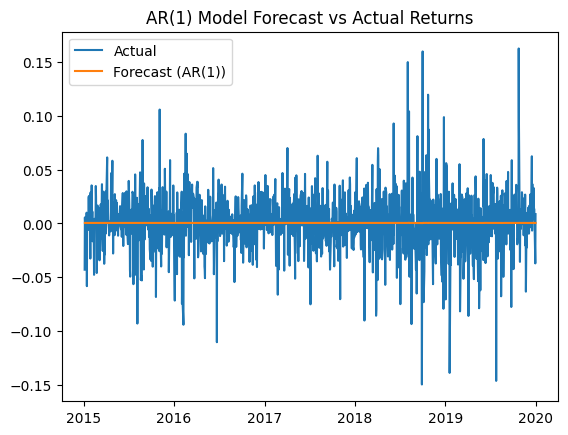

In [11]:
import matplotlib.pyplot as plt

best_model = ARIMA(log_ret_d['TSLA'].dropna(), order=(1, 0, 0)).fit()
fitted = best_model.fittedvalues
actual = log_ret_d['TSLA'].dropna()

plt.plot(actual, label="Actual")
plt.plot(fitted.shift(1), label="Forecast (AR(1))")
plt.legend()
plt.title("AR(1) Model Forecast vs Actual Returns")
plt.show()


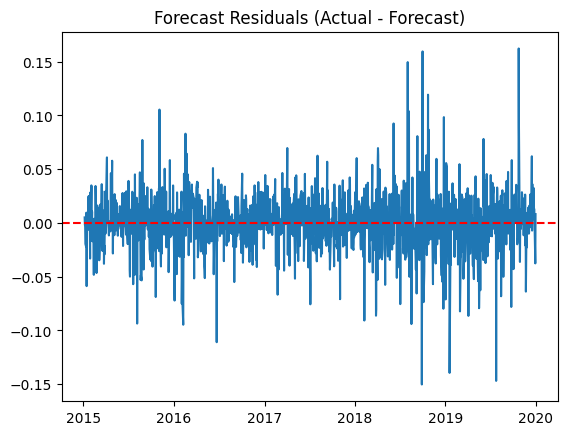

In [13]:
residuals = actual - fitted.shift(1)
plt.plot(residuals)
plt.title("Forecast Residuals (Actual - Forecast)")
plt.axhline(0, color='red', linestyle='--')
plt.show()


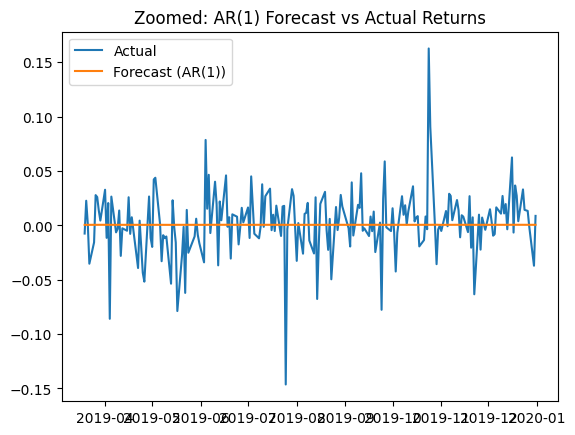

In [14]:
plt.plot(actual[-200:], label="Actual")
plt.plot(fitted.shift(1)[-200:], label="Forecast (AR(1))")
plt.legend()
plt.title("Zoomed: AR(1) Forecast vs Actual Returns")
plt.show()


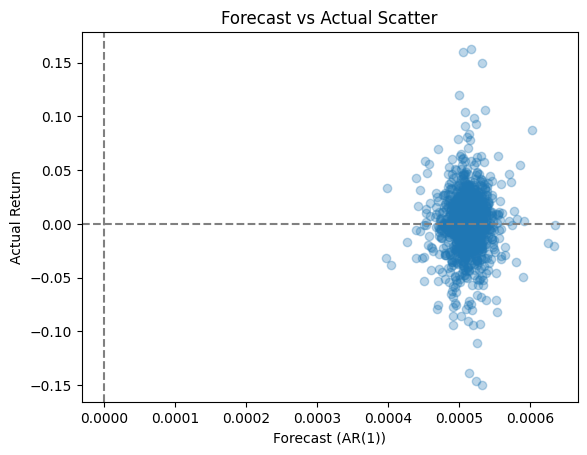

In [15]:
plt.scatter(fitted.shift(1)[1:], actual[1:], alpha=0.3)
plt.xlabel("Forecast (AR(1))")
plt.ylabel("Actual Return")
plt.title("Forecast vs Actual Scatter")
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.show()


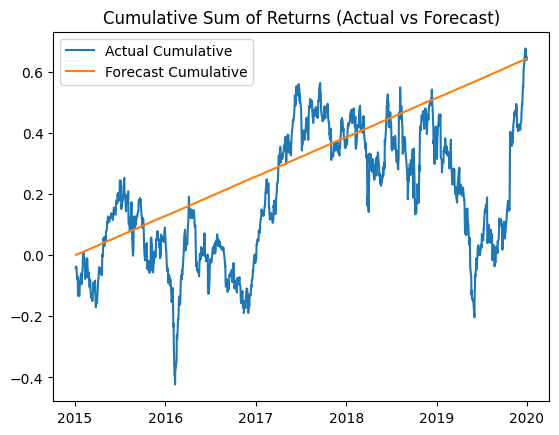

In [16]:
plt.plot(actual.cumsum(), label="Actual Cumulative")
plt.plot(fitted.shift(1).cumsum(), label="Forecast Cumulative")
plt.legend()
plt.title("Cumulative Sum of Returns (Actual vs Forecast)")
plt.show()


In [17]:
import numpy as np

# Parameters
n_paths = 10000
n_steps = 50
T = 5  # 5 years
dt = T / n_steps
recovery_rate = 0.4
hazard_rate = 0.02  # flat hazard
r = 0.01  # risk-free rate

# Simulate exposures: example, assume log-normal distributed positive exposure
np.random.seed(42)
exposure_paths = np.maximum(0, np.random.normal(loc=5, scale=2, size=(n_paths, n_steps)))

# Expected exposure (EE) at each step
EE = exposure_paths.mean(axis=0)

# Discount factors
DF = np.exp(-r * np.linspace(dt, T, n_steps))

# Marginal default probability at each step (assuming constant hazard rate)
PD = hazard_rate * np.exp(-hazard_rate * np.linspace(dt, T, n_steps)) * dt

# CVA calculation
cva = (1 - recovery_rate) * np.sum(EE * PD * DF)
print(f"Estimated CVA: {cva:.4f}")


Estimated CVA: 0.2783
